In [1]:
import tensorflow as tf

# 케라스 내장 데이터셋에서 mnist 로드
mnist = tf.keras.datasets.mnist

# 튜플로 훈련 검증 구분
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 로드된 데이터셋 확인
print('train set:', x_train.shape, y_train.shape)
print('test set:', x_test.shape, y_test.shape)

# 데이터 정규화
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

11493376/11490434 [==============================] - 0s 0us/step
train set: (60000, 28, 28) (60000,)
test set: (10000, 28, 28) (10000,)


# 1. 초기값 설정
- 레이어의 초기화 방법을 다르게 설정할 수 있음

In [2]:
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()['kernel_initializer']

{'class_name': 'GlorotUniform', 'config': {'seed': None}}

- 기본 초기화 방법으로 Glorot Uniform 설정

In [4]:
# 문자열 초기화
dense = tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')
print(dense.get_config()['kernel_initializer'])

# 클래스 인스턴스 초기화
he_normal = tf.keras.initializers.HeNormal()
dense = tf.keras.layers.Dense(256, kernel_initializer=he_normal, activation='relu')
print(dense.get_config()['kernel_initializer'])

{'class_name': 'HeNormal', 'config': {'seed': None}}
{'class_name': 'HeNormal', 'config': {'seed': None}}


# 2. 규제(Regularization)
- 모델의 과대적합을 해소하기 위해 L1, L2 규제를 적용
- 기본값으로 규제를 적용하지 않음. 따라서 별도 설정이 필요

In [5]:
# 기본값
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'dtype': 'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense_4',
 'trainable': True,
 'units': 256,
 'use_bias': True}

In [10]:
# l1 규제 적용
dense = tf.keras.layers.Dense(256, kernel_regularizer='l1', activation='relu')
print(dense.get_config()['kernel_regularizer'])

# 클래스 인스턴스 적용, alpha=0.1 변경
regularizer = tf.keras.regularizers.l1(l1=0.1)
dense = tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu')
print(dense.get_config()['kernel_regularizer'])

{'class_name': 'L1', 'config': {'l1': 0.009999999776482582}}
{'class_name': 'L1', 'config': {'l1': 0.10000000149011612}}


# 3. 드롭아웃(Dropout)
- 모델의 과대적합 문제를 해결하기 위해 제안된 아이디어
- 노드의 일부 신호를 임의로 삭제하면 모델이 과대적합 되는 것을 방지할 수 있음
    - 모델이 학습하는 가중치 파라미터의 개수가 현저하게 줄어들기 때문
- 모델이 훈련할 떄는 드롭아웃이 적용되지만, 예측시점에는 모든 노드 활용

In [11]:
# Dropout 25% 비율 적용(25% 노드 삭제)
tf.keras.layers.Dropout(0.25)

# 4. 배치 정규화(Batch Normalization)
- 각 층에서 활성화 함수를 통과하기 전 미니 배치의 스케일 정규화
- 다음 층으로 데이터가 전달되기 전에 스케일이 조정되므로 보다 안정적인 훈련 가능

In [12]:
# Model A: Dense + RELU
model_a = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model_a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Model B: Dense + BatchNorm + Relu
model_b = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(32),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model_b.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                50240     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)               

In [15]:
model_a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
model_b.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])

In [18]:
history_a = model_a.fit(x_train, y_train,
            validation_data=(x_test, y_test),
            epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0271 - acc: 0.9907 - val_loss: 0.1043 - val_acc: 0.9732
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0245 - acc: 0.9917 - val_loss: 0.1048 - val_acc: 0.9742
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0221 - acc: 0.9925 - val_loss: 0.1213 - val_acc: 0.9707
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0209 - acc: 0.9930 - val_loss: 0.1106 - val_acc: 0.9731
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0177 - acc: 0.9941 - val_loss: 0.1186 - val_acc: 0.9725
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0167 - acc: 0.9944 - val_loss: 0.1161 - val_acc: 0.9744
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0162 - acc: 0.9946 - val_loss: 0.1290 - val_acc: 0.9707
Epoch 8/10
1875/1875 [==============================] - 4s 2ms

In [19]:
history_b = model_b.fit(x_train, y_train,
            validation_data=(x_test, y_test),
            epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0501 - acc: 0.9839 - val_loss: 0.0781 - val_acc: 0.9772
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0478 - acc: 0.9842 - val_loss: 0.0793 - val_acc: 0.9761
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0466 - acc: 0.9841 - val_loss: 0.0793 - val_acc: 0.9774
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0428 - acc: 0.9854 - val_loss: 0.0795 - val_acc: 0.9774
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0416 - acc: 0.9860 - val_loss: 0.0754 - val_acc: 0.9789
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0388 - acc: 0.9873 - val_loss: 0.0821 - val_acc: 0.9759
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0370 - acc: 0.9873 - val_loss: 0.0871 - val_acc: 0.9777
Epoch 8/10
1875/1875 [==============================] - 5s 2ms

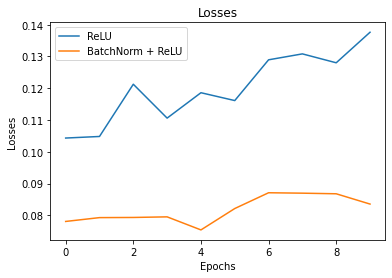

In [21]:
import matplotlib.pyplot as plt
plt.plot(history_a.history['val_loss'])
plt.plot(history_b.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses')
plt.legend(['ReLU', 'BatchNorm + ReLU'])
plt.show()

# 6. 활성화(Activation) 함수
- 기본 값은 ReLU이나, 다른 활성화 함수 적용 가능

In [22]:
# LeakyReLU 기본 설정
tf.keras.layers.LeakyReLU()

# LeakyReLU, alpha=0.2로 변경
tf.keras.layers.LeakyReLU(alpha=0.2)

In [24]:
# Model C: Dense + BatchNorm + LeakyReLU(0.2)
model_c = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dense(10, activation='softmax'),
])

model_c.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                50240     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32)               

In [25]:
model_c.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])
history_c = model_c.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3214 - acc: 0.9103 - val_loss: 0.1494 - val_acc: 0.9536
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1564 - acc: 0.9532 - val_loss: 0.1208 - val_acc: 0.9630
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1250 - acc: 0.9615 - val_loss: 0.1030 - val_acc: 0.9686
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1070 - acc: 0.9663 - val_loss: 0.0974 - val_acc: 0.9689
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0958 - acc: 0.9700 - val_loss: 0.0901 - val_acc: 0.9722
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0852 - acc: 0.9726 - val_loss: 0.0941 - val_acc: 0.9715
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0763 - acc: 0.9757 - val_loss: 0.0910 - val_acc: 0.9716
Epoch 8/10
1875/1875 [==============================] - 5s 2ms

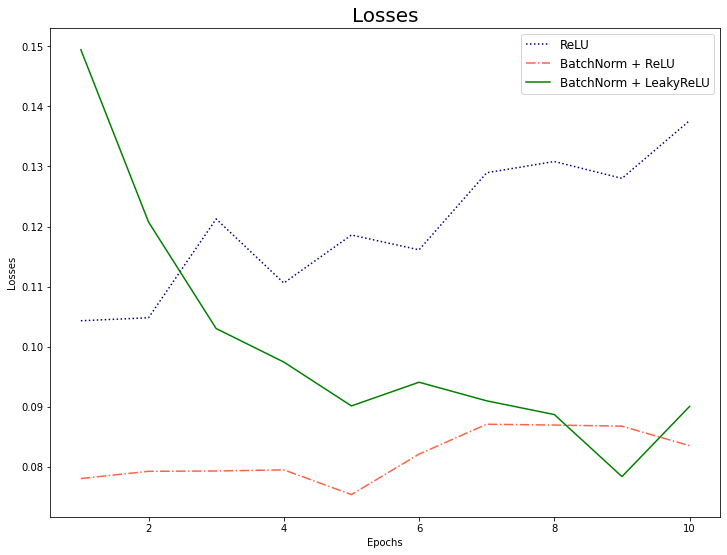

In [26]:
import numpy as np

plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, 11), history_a.history['val_loss'], color='navy', linestyle=':')
plt.plot(np.arange(1, 11), history_b.history['val_loss'], color='tomato', linestyle='-.')
plt.plot(np.arange(1, 11), history_c.history['val_loss'], color='green', linestyle='-')

plt.title('Losses', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['ReLU', 'BatchNorm + ReLU', 'BatchNorm + LeakyReLU'], fontsize=12)
plt.show()

- 배치 정규화를 적용하지 않았을 때 loss가 수렴하지 않음(배치 정규화 성능이 좋다)
